<a href="https://colab.research.google.com/github/Bibhash123/competition_quickstart_dataloader/blob/main/gbm-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is a sample jupyter notebook to generate the prediction for competition submission

### Download and import custom module from RCI repo to get latest dataset from IPFS

In [ ]:
# # download custom module from RCI github repo which enable us to download dataset directly from IPFS
# !wget -O dataloader.py https://raw.githubusercontent.com/rocketcapital-ai/competition_quickstart_dataloader/main/dataloader.py

# # import modules
# import sys, zipfile
# from google.colab import files

# # append the directory of downloaded custom module to system path so we can import it
# sys.path.append('/content/')

# # install base58 module to decrpt the dataset
# !pip install base58

# # import the downloaded module
# from dataloader import download_dataset

# # download latest dataset from IPFS
# filename = download_dataset()

# # unzip the file
# with zipfile.ZipFile(filename, 'r') as zip_ref:
#     zip_ref.extractall()


In [ ]:
from IPython.display import clear_output
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle datasets download -d "bericdondarion/rcidata"
!unzip rcidata.zip -d "/content/rci/"
!rm -r rcidata.zip
clear_output(wait = False)

## Imports

In [16]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [17]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

BATCH_SIZE = 32

In [18]:
def rank_data(series):
    return (series.rank() - 1) / (len(series) - 1)

## Data Loading

In [19]:
def build_generator(files, labelled = True):
  def load_data():
    for _,record in files.iterrows():
      if not pd.isnull(record['filename']):
        temp = np.load(record['filename'])
        if labelled:
          yield (temp['arr_0'], temp['arr_1']), record['target_DC1']
        else:
          yield (temp['arr_0'], temp['arr_1'])
      else:
        continue
  return load_data

def getDataset(files, batch = True, repeat = True, shuffle = True, labelled = True):
  datagen = build_generator(files, labelled)
  data = tf.data.Dataset.from_generator(datagen, output_signature = ((tf.TensorSpec(shape=(10,2011), dtype=tf.float32),
                                                                      tf.TensorSpec(shape=(10,1), dtype=tf.float32)),
                                                                      tf.TensorSpec(shape=(), dtype=tf.float32)))
  
  data = data.shuffle(1024) if shuffle else data
  data = data.batch(BATCH_SIZE) if batch else data
  data = data.repeat() if repeat else data
  return data

In [20]:
!mv "/content/rci/data" "/content/"

In [21]:
X_train = pd.read_csv("/content/data/train_files.csv")
X_test = pd.read_csv("/content/data/val_files.csv")
test_files = pd.read_csv("/content/data/test_files.csv")

In [33]:
train_data = getDataset(X_train, batch = True, shuffle = True, repeat = True, labelled = True)
val_data = getDataset(X_test, batch = True, shuffle = False, repeat = False, labelled = True)

# LSTM model building

In [34]:
class AttentionHead(L.Layer):
    def __init__(self, in_features, hidden_dim):
        super(AttentionHead,self).__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim
        self.W = L.Dense(hidden_dim)
        self.V = L.Dense(1)
        self.out_features = hidden_dim
        self.mul = L.Multiply()
    
    def call(self, features, attn_mask):
        att = tf.keras.activations.tanh(self.W(features))
        score = self.V(att)
        attention_weights = tf.keras.activations.softmax(score, axis=1)
        mod_attention_weights = self.mul([attn_mask, attention_weights])
        context_vector = mod_attention_weights * features
        context_vector = K.sum(context_vector, axis=1)

        return context_vector

In [24]:
def buildModel():
  inp1 = L.Input(shape = (10, 2011))
  inp2 = L.Input(shape = (10, 1))

  h1 = L.Dense(1024, activation = "tanh")(inp1)

  h1 = L.LSTM(256, return_sequences = True)(h1)
  h1 = L.LSTM(64, return_sequences = True)(h1)
  h = AttentionHead(64, 32)(h1, inp2)
  
  h = L.Dropout(0.1)(h)
  h = L.Dense(32, activation = "tanh")(h)
  h = L.Dropout(0.1)(h)
  h = L.Dense(16, activation = "tanh")(h)
  h = L.Dropout(0.1)(h)
  h = L.Dense(1, activation = "linear")(h)
  model = tf.keras.Model(inputs = [inp1, inp2], outputs=  h)
  opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
  loss = tf.keras.losses.Huber(delta = 0.1)
  model.compile(loss = "mse", optimizer = opt, metrics = [tf.keras.metrics.MeanSquaredError()])
  return model

model = buildModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 2011)]   0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 10, 256)      2322432     ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 10, 64)       82176       ['lstm[0][0]']                   
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                              

In [25]:
ckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5', monitor = 'val_loss', mode = 'min', save_best_only = True, 
                                          save_weights_only = True)
es = tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss', mode = 'min')

model.fit(train_data,
          epochs = 10,
          steps_per_epoch = X_train.shape[0]//BATCH_SIZE,
          validation_data = val_data,
          callbacks = [ckpt, es]
          )
# Higher learning rate higher batch size

Epoch 1/10
1950/1950 [==============================] - 362s 179ms/step - loss: 0.0763 - mean_squared_error: 0.0763 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 2/10
1950/1950 [==============================] - 351s 180ms/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 3/10
1950/1950 [==============================] - 350s 180ms/step - loss: 0.0730 - mean_squared_error: 0.0730 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 4/10
1950/1950 [==============================] - 352s 181ms/step - loss: 0.0734 - mean_squared_error: 0.0734 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 5/10
1950/1950 [==============================] - 351s 180ms/step - loss: 0.0736 - mean_squared_error: 0.0736 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 6/10
1950/1950 [==============================] - 348s 179ms/step - loss: 0.0739 - mean_squared_error: 0.0739 - val_loss: 0.0400 - val_mean_squared_error:

In [26]:
def getY(x,y):
  return y

def errorAnalysis(files_):
  files = files_.copy()
  trn = getDataset(files, batch = True, shuffle = False, repeat = False, labelled = True)
  model = buildModel()
  model.load_weights('model.hdf5')
  pred = model.predict(trn)
  files['error'] = (pred.flatten()-files['target_DC1'].values.flatten())**2
  return files

error = errorAnalysis(X_test)

In [27]:
error

,symbol,date,filename,target,target_DC1,error
0,0xBTC,2022-02-06,/content/data/0xBTC_file_2022-02-06.npz,0.386588,-0.086161,0.001882
1,1INCH,2022-02-06,/content/data/1INCH_file_2022-02-06.npz,0.297830,-0.111788,0.004762
2,1WO,2022-02-06,/content/data/1WO_file_2022-02-06.npz,0.633136,-0.032450,0.000107
3,2KEY,2022-02-06,/content/data/2KEY_file_2022-02-06.npz,0.848126,0.044536,0.007624
4,AAC,2022-02-06,/content/data/AAC_file_2022-02-06.npz,0.984221,0.337609,0.144694
...,...,...,...,...,...,...
11113,ZLW,2022-06-26,/content/data/ZLW_file_2022-06-26.npz,0.589744,-0.052424,0.000093
11114,ZORA,2022-06-26,/content/data/ZORA_file_2022-06-26.npz,0.460114,-0.087453,0.001996
11115,ZRX,2022-06-26,/content/data/ZRX_file_2022-06-26.npz,0.566952,-0.056024,0.000175
11116,ZYN,2022-06-26,/content/data/ZYN_file_2022-06-26.npz,0.975783,0.206789,0.062284


In [28]:
error[error['error']==np.max(error['error'])]

,symbol,date,filename,target,target_DC1,error
6802,APY,2022-05-15,/content/data/APY_file_2022-05-15.npz,0.0,-2.791786,7.557046


In [29]:
error[error['error']==np.min(error['error'])]

,symbol,date,filename,target,target_DC1,error
1783,PAY,2022-03-06,/content/data/PAY_file_2022-03-06.npz,0.539216,-0.042767,1.060067e-10


In [30]:
error[["target","target_DC1","error"]].corr()

,target,target_DC1,error
target,1.000000,0.684329,-0.040176
target_DC1,0.684329,1.000000,-0.092006
error,-0.040176,-0.092006,1.000000


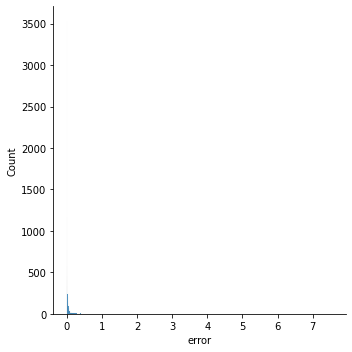

In [31]:
sns.displot(error['error'])

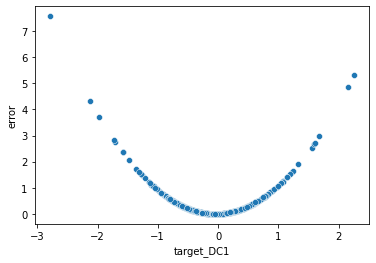

In [32]:
sns.scatterplot(x = "target_DC1", y = "error", data = error)

In [ ]:
train_dataset[(train_dataset['symbol']=="APY")&(train_dataset['date']=="2022-05-15")]

In [ ]:
np.load("/content/data/APY_file_2022-05-15.npz")['arr_0']

array([[0.17715827, 0.17266187, 0.17086331, ..., 0.3705036 , 0.17446043,
        0.60251799],
       [0.90730838, 0.84670232, 0.86631016, ..., 0.40998217, 0.29233512,
        0.87522282],
       [0.14576271, 0.8220339 , 0.50338983, ..., 0.31864407, 0.37288136,
        0.23220339],
       ...,
       [0.03068592, 0.79602888, 0.40974729, ..., 0.87725632, 0.83574007,
        0.67689531],
       [0.17440225, 0.03094233, 0.37552743, ..., 0.97468354, 0.97046414,
        0.4978903 ],
       [0.67482517, 0.17762238, 0.01678322, ..., 0.8993007 , 0.93566434,
        0.32027972]])

In [ ]:
np.load("/content/data/APY_file_2022-05-15.npz")['arr_1']

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
 !cp "model.hdf5" "/content/rci/"

### Use simple XGBoost to train a model

In [ ]:
X_train = pd.read_csv("/content/rci/data/train_files.csv")
X_test = pd.read_csv("/content/rci/data/val_files.csv")
test_files = pd.read_csv("/content/rci/data/test_files.csv")

In [ ]:
def buildModel():
  inp = L.Input(shape = (10, 2010))
  h = L.Bidirectional(L.LSTM(512, return_sequences = True), merge_mode = "ave")(inp)
  h = AttentionHead(2010, 512)(h)
  h = L.Dense(128, activation = "relu")(h)
  h = L.Dense(16, activation = "relu")(h)
  h = L.Dense(1, activation = "linear")(h)
  model = tf.keras.Model(inputs = inp, outputs=  h)
  model.compile(loss = "mse", optimizer = "adam")
  return model

model = buildModel()
model.load_weights("/content/rci/model.hdf5")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 2010)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 512)          10334208  
 l)                                                              
                                                                 
 attention_head (AttentionHe  (None, 512)              263169    
 ad)                                                             
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 16)                2064      
                                                                 
 dense_4 (Dense)             (None, 1)                 17    

In [ ]:
def loadSet(files, labelled = True):
  x,ydc,y = [],[],[]
  for _,row in files.iterrows():
    x.append(np.load(row['filename'], allow_pickle = True)['arr_0'][-1])
    ydc.append(row['target_DC1'])
    y.append(row['target'])      
  return np.stack(x, axis = 0), np.stack(ydc, axis = 0), np.stack(y, axis = 0)

In [ ]:
!mv "/content/rci/data" "/content/"

In [ ]:
# test_data = loadSet(test_files, validation_dataset, labelled = False)
X_train_plain, Y_train_plain, target_train_plain = loadSet(X_train)
X_test_plain, Y_test_plain, target_test_plain = loadSet(X_test)

In [ ]:
from xgboost import XGBRegressor

params = {'objective' : "reg:squarederror", 
          'n_estimators' : 1000, 
          'tree_method' : "gpu_hist", 
          'max_depth':9, 
          "reg_alpha":0.01
          }

reg = XGBRegressor(**params)
reg.fit(X_train_plain, Y_train_plain, eval_metric = "rmse",
        eval_set=[(X_train_plain,Y_train_plain),(X_test_plain, Y_test_plain)], 
        early_stopping_rounds = 10, verbose = 10)

[0]	validation_0-rmse:0.527322	validation_1-rmse:0.548756
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[56]	validation_0-rmse:0.148903	validation_1-rmse:0.21828



XGBRegressor(max_depth=9, n_estimators=1000, objective='reg:squarederror',
             reg_alpha=0.01, tree_method='gpu_hist')

In [ ]:
def predictFunction(lstm,xgb,files_df):
  files = files_df.copy()
  lstm_pred = []
  xgb_pred = []
  for _,row in tqdm(files.iterrows(), total =files.shape[0]):
    if pd.isnull(row['filename']):
      lstm_pred.append(0.0)
      xgb_pred.append(xgb.predict(np.expand_dims(np.load(row['filename'],allow_pickle=True)['arr_0'][-1],axis = 0))[0])
    else:
      lstm_pred.append(lstm.predict(np.expand_dims(np.load(row['filename'],allow_pickle=True)['arr_0'],axis = 0).astype(np.float32))[0])
      xgb_pred.append(xgb.predict(np.expand_dims(np.load(row['filename'],allow_pickle=True)['arr_0'][-1],axis = 0).astype(np.float32))[0])

  lstm_pred = np.stack(lstm_pred)
  xgb_pred = np.stack(xgb_pred)
  mask = lstm_pred == 0
  mask = mask[:,0]
  if np.any(mask):
    lstm_pred[mask] = lstm_pred[mask]+xgb_pred[mask]
  files.loc[:,'predicted_DC1'] = (lstm_pred.reshape((-1,1))+xgb_pred.reshape((-1,1)))/2
  files.loc[:,'predicted_target'] = -1
  for date in files.date.unique():
    files.loc[files['date']==date,'predicted_target'] = rank_data(files[files['date']==date]['predicted_DC1'])
  return files

In [ ]:
# function to calculate Spearman correlation by era (mean, std, max, min)
# we want to maximize but maintain stable correlation across era to maximize both challenge and competition reward
def spearman_by_era(prediction,target, dates):
  df = pd.DataFrame(index=dates,
                    data = {'prediction': prediction,
                            'target': target}
                    )
  
  spearman_era_list = []
  for era in df.index.unique():
    era_df = df[df.index == era]
    spearman_corr = sp.stats.spearmanr(era_df.prediction, era_df.target)[0]
    spearman_era_list.append(spearman_corr)

  mean = np.mean(spearman_era_list)
  std = np.std(spearman_era_list)
  max = np.max(spearman_era_list)
  min = np.min(spearman_era_list)
  return mean, std, max, min
  

In [ ]:
pred_train = predictFunction(model,reg, X_train)
train_spearman = spearman_by_era(pred_train['predicted_target'].values, target_train_plain,
                                pred_train['date'].values)

print('Train dataset Spearman correlation: mean = {} ; std = {} ; max = {} ; min = {}'.format(round(train_spearman[0], 4), 
                                                                                            round(train_spearman[1], 4),
                                                                                            round(train_spearman[2], 4),
                                                                                            round(train_spearman[3], 4),
                                                                                            ))


In [ ]:
pred_val = predictFunction(model,reg, X_test)
test_spearman = spearman_by_era(pred_val['predicted_target'].values, target_test_plain,
                                pred_val['date'].values)
print('Test dataset Spearman correlation: mean = {} ; std = {} ; max = {} ; min = {}'.format(round(test_spearman[0], 4),
                                                                                            round(test_spearman[1], 4),
                                                                                            round(test_spearman[2], 4),
                                                                                            round(test_spearman[3], 4),
                                                                                            ))


Test dataset Spearman correlation: mean = 0.076 ; std = 0.0611 ; max = 0.1821 ; min = -0.0578


In [ ]:
pred_submission = predictFunction(model,reg, test_files)

0it [00:00, ?it/s]

In [ ]:
# Use the trained Linear Regression model to make prediction on latest data
# X_validation = validation_dataset.iloc[:, 1:-2]
# y_validation_linear_reg = reg.predict(X_validation)
y_validation_linear_reg = pred_submission['predicted_target'].values
y_validation_linear_reg[:5]

array([0.70359281, 0.1002994 , 0.22005988, 0.23652695, 0.34730539])

### Let's use the prediction from linear regression to join with validation dataset symbol for submission

In [ ]:
prediction = pd.DataFrame()
prediction['symbol'] = list(pred_submission.symbol)
prediction['prediction'] = y_validation_linear_reg

# sort the prediction to check which symbol is weaker and stronger, ie. FOX is weakest; BTC is strongest
prediction.sort_values('prediction')

,symbol,prediction
361,MYB,0.000000
573,TONE,0.001497
103,CLR,0.002994
473,RDN,0.004491
94,CEL,0.005988
...,...,...
668,eRSDL,0.994012
590,UBEX,0.995509
293,L2,0.997006
431,POA,0.998503


### Check is prediction dataframe in accordance for submission format (using the prediction from linear regression)

In [ ]:
#check if y_latest is in accordance to shape for submission
if set(prediction.symbol) == set(validation_dataset.symbol):
    print('symbol matched!')
else:
    print('symbol unmatched, the symbol in prediction df must match the symbol in validation_dataset...')
    
if prediction.shape[1] == 2:
    print('column counts ok!')
else:
    print('It should have 2 columns, first column with symbol, second with prediction...')


symbol matched!
column counts ok!


### Output prediction as a .csv file for submission!

In [ ]:
#Output submission as .csv file
#The prediction.csv is stored in content/prediction folder
import os
if not os.path.exists('/content/prediction'):
    os.makedirs('/content/prediction')
prediction.to_csv('/content/prediction/prediction.csv', index = False, header = None)

# **Submission Section**

## **Setup**

In [ ]:
!git clone https://github.com/rocketcapital-ai/competition_submission.git
%cd /content/competition_submission

Cloning into 'competition_submission'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 3), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (23/23), done.
/content/competition_submission


In [ ]:
!pip install base58
!pip install PyYAML
!pip install requests
!pip install web3
!pip install pandas 
from IPython.display import clear_output
clear_output(wait = False)

In [ ]:
from lib.submitter import *

jwt = 'eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJ1c2VySW5mb3JtYXRpb24iOnsiaWQiOiIxMDIwZDY0OC1kNzQ5LTQ5YjItOTZmZS1hNWQ0NDY5ODRjNTQiLCJlbWFpbCI6ImJpYmhhc2hwLmRhc0BnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwicGluX3BvbGljeSI6eyJyZWdpb25zIjpbeyJpZCI6IkZSQTEiLCJkZXNpcmVkUmVwbGljYXRpb25Db3VudCI6MX0seyJpZCI6Ik5ZQzEiLCJkZXNpcmVkUmVwbGljYXRpb25Db3VudCI6MX1dLCJ2ZXJzaW9uIjoxfSwibWZhX2VuYWJsZWQiOmZhbHNlLCJzdGF0dXMiOiJBQ1RJVkUifSwiYXV0aGVudGljYXRpb25UeXBlIjoic2NvcGVkS2V5Iiwic2NvcGVkS2V5S2V5IjoiYmM4NWI0ZDQ1N2FhYWZlNzBmNGIiLCJzY29wZWRLZXlTZWNyZXQiOiJlMmEyOGFlZmFlNTcyMWZkNzM1Mjg4NzE5OTIzYTBkZTQ4MWY5NzUxZWQyZmVhMTE0MGJmYzRlNzNjNzRhYzI2IiwiaWF0IjoxNjU1MTM2Nzc4fQ.xl2FxgrL04kQIa7cIn89a_iE0I9xphiNf6K5K2mor5o'      # User-specified field.
address = '0xcF16365d53ed53055f39010830e3CcD5A7a8245E'  # User-specified field.
pk = '32316dfe607ed4a240ac29a6dcad9db6f484f0fbdf7894c15511237e1e13db70'       # User-specified field.
submitter = Submitter(jwt, address, pk)

## View wallet address information.

In [ ]:
print('MATIC balance for {}: {}'.format(submitter.address, submitter.get_matic_balance()))
print('MUSA balance for {}: {}'.format(submitter.address, submitter.get_musa_balance()))
print('Current stake for {}: {}'.format(submitter.address, submitter.get_stake()))

MATIC balance for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 1.032258504668605866
MUSA balance for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 25.869313545300001154
Current stake for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 100.000000000000000000


## **Retrieve Dataset and run models.**
### Please follow the instructions and example found [here](https://github.com/rocketcapital-ai/competition_quickstart_dataloader).

### When completed, please place final prediction csv file in the `file_to_submit` folder.

In [ ]:
!cp "/content/prediction/prediction.csv" "/content/competition_submission/file_to_submit/"

## **Set stake.** (optional)
### Skip if no changes need to be made.

In [ ]:
set_stake_amount = 125.00  # User-specified field.
transaction_success = submitter.set_stake(set_stake_amount)
assert transaction_success, 'Setting stake failed.'

Setting gas price to 65 gwei.
Sending transaction 0xe3cf8d0d27ab1452e097706b3ceb1c3bb6f4ab91c181af5e21588934c3d82469
Transaction sent. Tx ID: 0xe3cf8d0d27ab1452e097706b3ceb1c3bb6f4ab91c181af5e21588934c3d82469


## **Submit predictions.**
Note that the same `submit_prediction` method should be used for re-submitting predictions.

In [ ]:
submission_file_name = 'prediction.csv'  # User-specified field.
transaction_success = submitter.submit_prediction(submission_file_name)
assert transaction_success, 'Submission failed.'

Encrypting file.
Zipping encrypted file.
Uploading and recording on blockchain.
Setting gas price to 68 gwei.
Sending transaction 0xd15c69d2bd8b878ff18d1fbcd6eb906ee1a87a67188eb3bac799ce1a017b95a2
Transaction sent. Tx ID: 0xd15c69d2bd8b878ff18d1fbcd6eb906ee1a87a67188eb3bac799ce1a017b95a2


### **Retrieve and double-check predictions.** (optional)
This section retrieves your submitted files, decrypts them, and compares them to the original file in `file_to_submit`.

If the verification fails, please wait a few minutes and perform the verification again. If the problem persists, please re-submit your predictions.

In [ ]:
verification_success = submitter.download_and_check(submission_file_name)
assert verification_success, 'Submission verification failed.'
print('Files are identical. Verification check passed.')

Retrieving file.
File retrieved.
File unzipped.
File decrypted. Comparing files.
Removing temp files.
Temp files removed.
Files are identical. Verification check passed.


# **Data Preparation**

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
!wget https://rocketcompetition.mypinata.cloud/ipfs/QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg
!unzip -q QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg -d "/content/"
!rm -r QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg

--2022-07-04 10:31:46--  https://rocketcompetition.mypinata.cloud/ipfs/QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg
Resolving rocketcompetition.mypinata.cloud (rocketcompetition.mypinata.cloud)... 104.18.31.237, 104.18.30.237, 2606:4700::6812:1eed, ...
Connecting to rocketcompetition.mypinata.cloud (rocketcompetition.mypinata.cloud)|104.18.31.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361466596 (345M) [application/zip]
Saving to: ‘QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg’

QmPGWzSzxtPBEoFFxKr 100%[===================>] 344.72M  94.4MB/s    in 4.0s    

2022-07-04 10:31:52 (85.1 MB/s) - ‘QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg’ saved [361466596/361466596]

replace /content/Quickstart.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### Loading train_dataset and validation_dataset

In [2]:
train_dataset  = pd.read_csv('/content/dataset/train_dataset.csv', index_col = 'date')
validation_dataset  = pd.read_csv('/content/dataset/validation_dataset.csv', index_col = 'date')
print("Shape of train set:",train_dataset.shape)
print("Shape of test set:",validation_dataset.shape)

Shape of train set: (81895, 2013)
Shape of test set: (719, 2013)


In [3]:
train_dataset = train_dataset.sort_values(by=["symbol","date"]).reset_index(drop=False)
validation_dataset = validation_dataset.sort_values(by=["symbol","date"]).reset_index(drop=False)

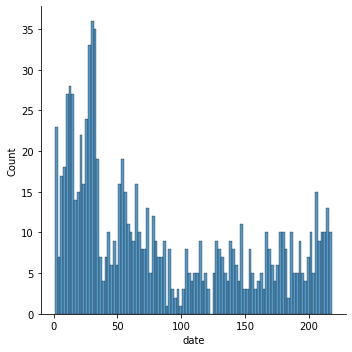

In [4]:
df = train_dataset.groupby("symbol")['date'].count().to_frame().reset_index()
sns.displot(df['date'],bins = 100)

In [5]:
# first column (symbol) is the ticker
# 'target_DC1' is the log of return for delta between current close to previous close
# 'target' is the y which is ranked by Era using 'target_DC1'
# the rest of the columns are features to be used for ML
train_dataset.head()

,date,symbol,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_2003,feature_2004,feature_2005,feature_2006,feature_2007,feature_2008,feature_2009,feature_DC1,target,target_DC1
0,2018-12-23,0xBTC,0.974026,0.987013,0.978355,0.991342,0.982684,0.982684,0.982684,0.978355,...,0.887446,0.857143,0.857143,0.857143,0.835498,0.839827,0.839827,0.891775,0.095238,-0.211551
1,2018-12-30,0xBTC,0.016878,0.033755,0.949367,0.936709,0.978903,0.907173,0.962025,0.953586,...,0.936709,0.953586,0.962025,0.932489,0.940928,0.945148,0.915612,0.101266,0.046414,-0.192849
2,2019-01-06,0xBTC,0.158996,0.016736,0.033473,0.928870,0.868201,0.941423,0.740586,0.933054,...,0.891213,0.874477,0.857741,0.912134,0.849372,0.807531,0.878661,0.050209,0.284519,-0.263822
3,2019-01-13,0xBTC,0.737500,0.279167,0.020833,0.054167,0.945833,0.908333,0.962500,0.870833,...,0.645833,0.600000,0.541667,0.691667,0.591667,0.504167,0.670833,0.287500,0.391667,0.023985
4,2019-01-20,0xBTC,0.983607,0.987705,0.983607,0.430328,0.971311,0.991803,0.987705,0.991803,...,0.504098,0.454918,0.422131,0.553279,0.368852,0.331967,0.450820,0.397541,0.032787,-0.251842


In [6]:
symbols = train_dataset.symbol.unique()
trainsize = train_dataset.shape[0]
train_dataset = pd.concat([train_dataset, validation_dataset], axis = 0)
train_dataset['dc1_lag1'] = -1
for sym in tqdm(symbols):
  train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag1'] = train_dataset[train_dataset['symbol']==sym]['target_DC1'].shift(1)

train_dataset.fillna(-1,inplace = True)
validation_dataset = train_dataset.iloc[trainsize:]
train_dataset = train_dataset.iloc[:trainsize]

  0%|          | 0/964 [00:00<?, ?it/s]

## Create Records

In [7]:
symbols = train_dataset.symbol.unique()

def prepareData(dataframe, savedir, window = 10):
  if not os.path.isdir(savedir):
    os.mkdir(savedir)

  records = []
  for sym in tqdm(symbols, "Preparing Train Data"):
    values = dataframe[dataframe['symbol']==sym].drop(["target",	"target_DC1", "date", "symbol"], axis = 1).values
    attention = np.ones((values.shape[0],1))
    dates = dataframe[dataframe['symbol']==sym]['date'].values
    targets = dataframe[dataframe['symbol']==sym]['target'].values
    targets_dc1 = dataframe[dataframe['symbol']==sym]['target_DC1'].values
    if values.shape[0]<window:
      values = np.concatenate([values, np.zeros((window-values.shape[0], values.shape[1]))], axis=0)
      attention = np.concatenate([attention, np.zeros((window-attention.shape[0], 1))], axis=0)
      targets = np.concatenate([targets, np.repeat(targets[-1],window-targets.shape[0], axis = 0)], axis=0)
      targets_dc1 = np.concatenate([targets_dc1, np.repeat(targets_dc1[-1],window-targets_dc1.shape[0], axis = 0)], axis=0)
      dates = np.concatenate([dates, np.repeat(dates[-1],window-dates.shape[0], axis = 0)], axis=0)

    n = values.shape[0]
    for i in range(window,n+1,1):
      temp = values[i-window:i]
      attn = attention[i-window:i]
      t = targets[i-1]
      tdc1 = targets_dc1[i-1]
      d = dates[i-1]
      filename = os.path.join(savedir, f"{sym}_file_{d}.npz")
      np.savez(filename, temp, attn)
      records.append([sym, d, filename, t, tdc1])

  files = pd.DataFrame(np.stack(records, axis = 0), columns = ["symbol", "date", "filename", "target", "target_DC1"])
  files = files.sort_values(by = ['date','symbol'])
  return files

def preparedValData(train_files, dataframe, savedir, window = 10):
  if not os.path.isdir(savedir):
    os.mkdir(savedir)

  records = []
  test_symbols = dataframe.symbol.unique()
  assert len(test_symbols)<= dataframe.shape[0], f"Length of dataframe greater than {len(test_symbols)}"

  for sym in tqdm(test_symbols, "Preparing test data"):
    if sym not in symbols:
      records.append([sym, np.nan, np.nan])
      continue

    rec = np.load(train_files[train_files["symbol"] == sym].iloc[-1,-3])['arr_0']
    assert rec.shape[-1]==2011, f"Incorrect shape of record: {rec.shape}"
    new_rec = np.expand_dims(dataframe[dataframe['symbol']==sym].iloc[0,2:-2].values,axis=0)
    new_rec = np.concatenate([rec[1:,:], new_rec],axis=0)

    assert new_rec.shape==(10,2011), f"Incorrect shape of new record {new_rec.shape}"
    d = dataframe[dataframe['symbol']==sym]['date'].values[0]
    filename = os.path.join(savedir, f"{sym}_file_{d}.npz")
    np.savez(filename, new_rec, axis = 0)
    records.append([sym, d, filename])

  files = pd.DataFrame(np.stack(records, axis = 0), columns = ["symbol", "date", "filename"])
  files = files.sort_values(by = ['date','symbol'])
  return files

In [8]:
train_files = prepareData(train_dataset, "/content/data")

Preparing Train Data:   0%|          | 0/964 [00:00<?, ?it/s]

In [9]:
test_files = preparedValData(train_files, validation_dataset, "/content/data")

Preparing test data:   0%|          | 0/719 [00:00<?, ?it/s]

### Create X and y from train_dataset

### Each era representing a set of cryptocurrency assets for the time period, the number of assets within each Era is different

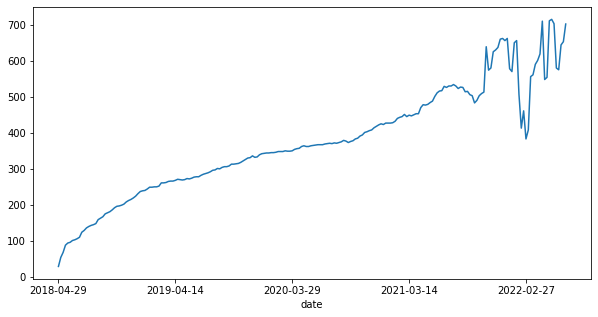

In [10]:
train_dataset.groupby(train_dataset.date).count().iloc[:,1].plot(figsize = (10,5));

### Split dataset into train and test by era

In [11]:
# Run Once
train = 0.9
test = 0.1
era = len(train_files.date.unique())
train_era = int(era * train)
test_era = era - train_era
print('total Era: {}'.format(era))
print('train Era: {}'.format(train_era))
print('validation Era: {}'.format(test_era))

total Era: 209
train Era: 188
validation Era: 21


In [12]:
#split train and test set according to the train_era and test_era
# Run Once
X_train = train_files.loc[train_files.date < train_files.date.unique()[train_era]]
X_test = train_files.loc[train_files.date >= train_files.date.unique()[train_era]]
print('Train dataset shape: {}'.format(X_train.shape))
print('Validation dataset shape: {}'.format(X_test.shape))

Train dataset shape: (62410, 5)
Validation dataset shape: (11118, 5)


In [13]:
# Run Once
X_train.to_csv("/content/data/train_files.csv", index = False)
X_test.to_csv("/content/data/val_files.csv", index = False)
test_files.to_csv("/content/data/test_files.csv", index = False)
# !cp -r "/content/data" "/content/gdrive/MyDrive/rci-competition/"

In [28]:
from IPython.display import clear_output
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle datasets download -d "bericdondarion/rcidata"
!unzip rcidata.zip -d "/content/rci/"
!rm -r rcidata.zip
clear_output(wait = False)

In [14]:
if os.path.isdir("/content/rci/data"):
  !rm -r "/content/rci/data"

!mv "/content/data" "/content/rci/data"
# !kaggle datasets init -p "/content/rci/"

In [15]:
!kaggle datasets version -p "/content/rci/" -m "Data for new week" --dir-mode tar

Starting upload for file model.hdf5
100% 40.7M/40.7M [00:09<00:00, 4.61MB/s]
Upload successful: model.hdf5 (41MB)
Starting upload for file data.tar
100% 11.3G/11.3G [09:36<00:00, 21.0MB/s]
Upload successful: data.tar (11GB)
Dataset version is being created. Please check progress at https://www.kaggle.com/bericdondarion/rcidata
